In [8]:
import xarray as xr
import numpy as np
import pandas as pd


# Load the NetCDF file
file_path = "wokslh.nc"
ds = xr.open_dataset(file_path)

# Constants
g = 9.81  # gravity [m/s^2]
omega = 7.2921e-5  # Earth's rotation rate [rad/s]
deg2rad = np.pi / 180
Re = 6371000  # Earth radius [m]

# Extract coordinates and SSH
lat = ds.latitude
lon = ds.longitude
ssh = ds["zos_glor"]

# Compute Coriolis parameter f
lat_rad = np.deg2rad(lat)
f = 2 * omega * np.sin(lat_rad)
f = f.broadcast_like(ssh.isel(time=0))

dx = 111000 * np.cos(np.deg2rad(lat))  # Convert degrees to meters (longitude)
dy = 111000  # Approximate 1° latitude in meters

# # Compute grid spacing
# dy = (lat.diff("latitude") * deg2rad * Re).mean().item()
# dx = (lon.diff("longitude") * deg2rad * Re * np.cos(lat_rad)).mean().item()

# Compute spatial gradients of SSH
dssh_dy = ssh.differentiate("latitude") / dy
dssh_dx = ssh.differentiate("longitude") / dx

# Compute geostrophic velocities
u_geo = -g / f * dssh_dy
v_geo = g / f * dssh_dx

# Select training period
u_train = u_geo.sel(time=slice("1993-01-01", "2020-12-31"))
v_train = v_geo.sel(time=slice("1993-01-01", "2020-12-31"))

# Compute daily climatology
u_clim = u_train.groupby("time.dayofyear").mean("time")
v_clim = v_train.groupby("time.dayofyear").mean("time")

# Compute velocity anomalies
u_anom = u_geo.groupby("time.dayofyear") - u_clim
v_anom = v_geo.groupby("time.dayofyear") - v_clim

# Compute EKE
eke = 0.5 * (u_anom**2 + v_anom**2)


eke_train = eke.sel(time=slice("1993-01-01", "2020-12-31")).mean(dim=['latitude', 'longitude'])
eke_test = eke.sel(time=slice("2021-01-01", "2022-12-31")).mean(dim=['latitude', 'longitude'])

In [9]:
# Flattening for ML
sla = ssh  # Rename for clarity

sla_train = sla.sel(time=slice("1993-01-01", "2020-12-31")).mean(dim=['latitude', 'longitude'])
sla_test = sla.sel(time=slice("2021-01-01", "2022-12-31")).mean(dim=['latitude', 'longitude'])

In [10]:
eke_train

<xarray.DataArray (time: 10227)> Size: 82kB
array([0.01974894, 0.0197014 , 0.01982293, ..., 0.03296759, 0.03317675,
       0.02530326])
Coordinates:
  * time       (time) datetime64[ns] 82kB 1993-01-01 1993-01-02 ... 2020-12-31
    dayofyear  (time) int64 82kB 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [11]:


# Reshape for ML: (samples, features)
X_train = sla_train.values
X_test = sla_test.values

y_train = eke_train.values
y_test = eke_test.values

# --- Remove NaNs and reshape ---
train_mask = ~np.isnan(X_train) & ~np.isnan(y_train)
X_train = X_train[train_mask].reshape(-1, 1)
y_train = y_train[train_mask]

test_mask = ~np.isnan(X_test) & ~np.isnan(y_test)
X_test = X_test[test_mask].reshape(-1, 1)
y_test = y_test[test_mask]



In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [13]:
model = RandomForestRegressor(n_estimators=50, random_state=0)
model1 = LinearRegression()
model2 = SVR(kernel="rbf")
model3 = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=0)
model4 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)


In [14]:
np.corrcoef(X_train[:,0],y_train)

array([[1.        , 0.33904563],
       [0.33904563, 1.        ]])

In [15]:


# --- Train model ---

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
corr = np.corrcoef(y_test.flatten(), y_pred.flatten())[0, 1]

print(f"\n✅ Evaluation for 2021–2022:")
print(f"   RMSE: {rmse:.5f}")
print(f"   Correlation: {corr:.3f}")



✅ Evaluation for 2021–2022:
   RMSE: 0.01330
   Correlation: 0.125


In [16]:
time=ds['time']
time_train=time.sel(time=slice("1993-01-01", "2020-12-31"))
time_test=time.sel(time=slice("2021-01-01", "2022-12-31"))           

In [17]:
y_pred.shape

(730,)

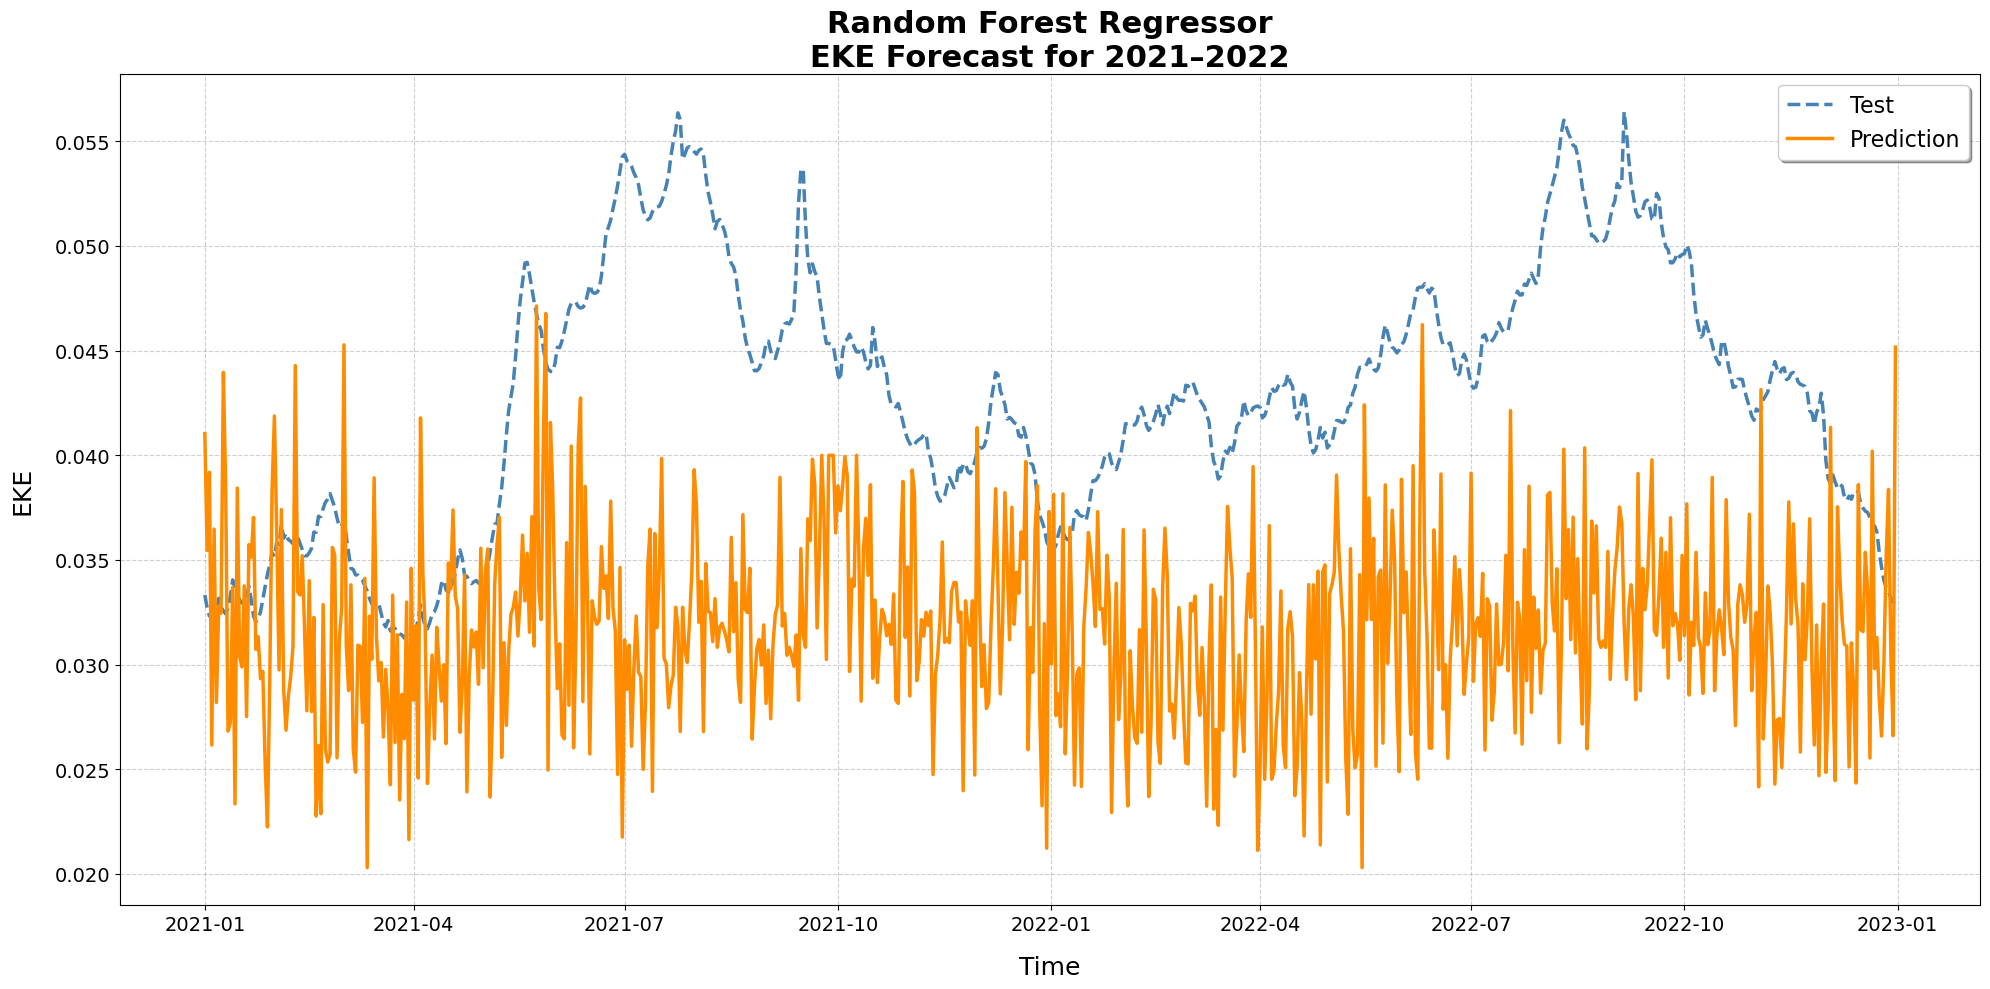

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Plotting lines with thicker widths and different styles
plt.plot(time_test, y_test, label='Test', color='steelblue', linewidth=2.5, linestyle='--')
plt.plot(time_test, y_pred, label='Prediction', color='darkorange', linewidth=2.5)

# Axis labels and title
plt.xlabel('Time', fontsize=18, labelpad=15)
plt.ylabel('EKE', fontsize=18, labelpad=15)
plt.title('Random Forest Regressor\nEKE Forecast for 2021–2022', fontsize=22, fontweight='bold')

# Tick formatting
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Grid
plt.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(fontsize=16, loc='upper right', frameon=True, shadow=True)

# Add a subtle background color
# plt.gca().set_facecolor('#f7f7f7')

# Tight layout for better spacing
plt.tight_layout()

plt.show()


In [19]:
# --- Linear Regression model ---

model1.fit(X_train, y_train)


y_pred1 = model1.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
corr1 = np.corrcoef(y_test.flatten(), y_pred1.flatten())[0, 1]

print(f"\n✅ Evaluation for 2021–2022:")
print(f"   RMSE: {rmse1:.5f}")
print(f"   Correlation: {corr1:.3f}")


✅ Evaluation for 2021–2022:
   RMSE: 0.01235
   Correlation: 0.639


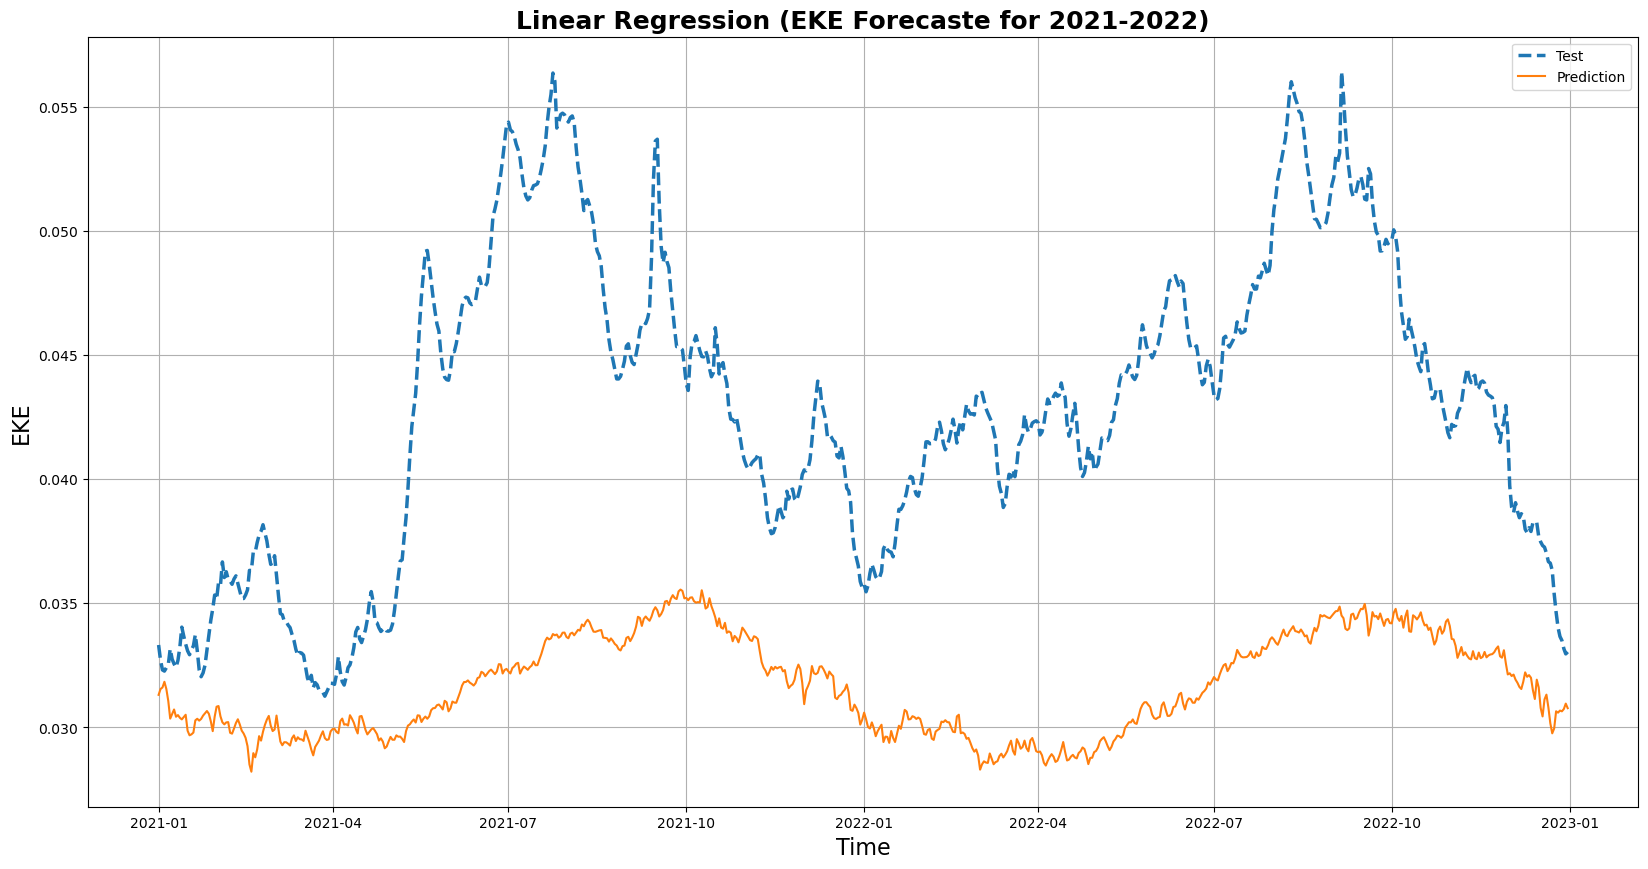

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# plt.plot(time_train, y_train)
plt.plot(time_test, y_test, label='Test',linewidth=2.5, linestyle='--')
plt.plot(time_test, y_pred1, label='Prediction')
plt.xlabel('Time', fontsize=16)
plt.ylabel('EKE', fontsize=16)
plt.title('Linear Regression (EKE Forecaste for 2021-2022)', fontsize=18, fontweight='bold')
plt.grid()
plt.legend()


✅ Evaluation for 2021–2022:
   RMSE: 0.01278
   Correlation: 0.283


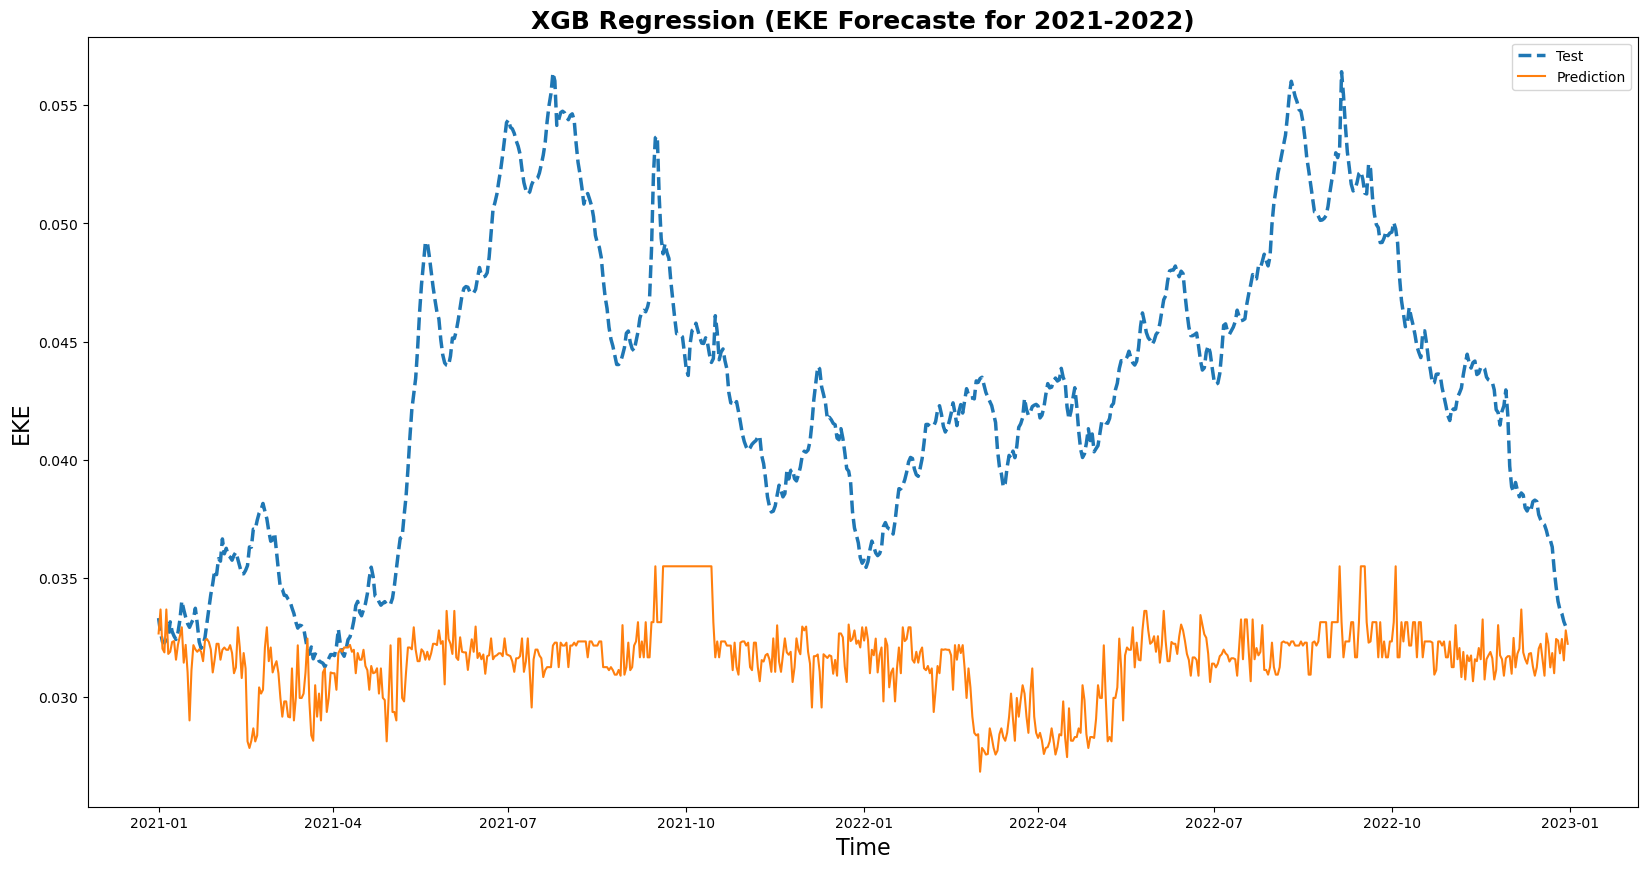

In [21]:
# --- Linear Regression model ---

model4.fit(X_train, y_train)


y_pred4 = model4.predict(X_test)
rmse4 = np.sqrt(mean_squared_error(y_test, y_pred4))
corr4 = np.corrcoef(y_test.flatten(), y_pred4.flatten())[0, 1]

print(f"\n✅ Evaluation for 2021–2022:")
print(f"   RMSE: {rmse4:.5f}")
print(f"   Correlation: {corr4:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# plt.plot(time_train, y_train)
plt.plot(time_test, y_test, label='Test',linewidth=2.5, linestyle='--')
plt.plot(time_test, y_pred4, label='Prediction')
plt.xlabel('Time', fontsize=16)
plt.ylabel('EKE', fontsize=16)
plt.title('XGB Regression (EKE Forecaste for 2021-2022)', fontsize=18, fontweight='bold')
plt.legend()

In [22]:
rmse = [0.01330, 0.01278,0.01235]
model = ["RandomForestRegression","XGBoost","LinearRegression"]

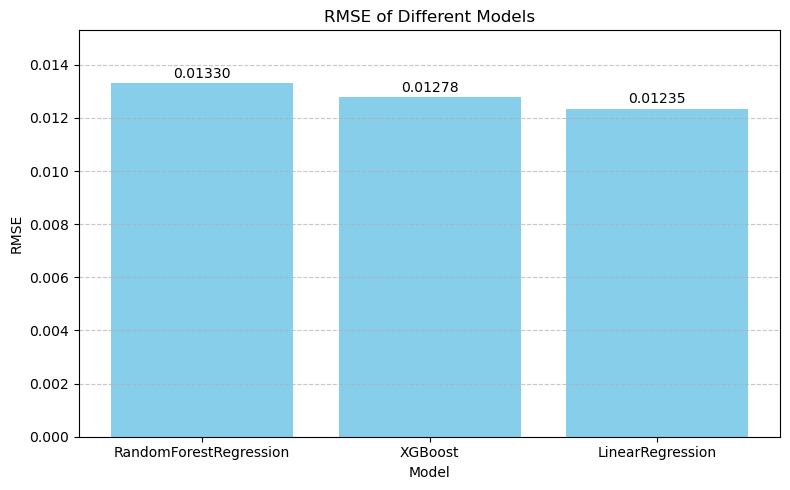

In [23]:
import matplotlib.pyplot as plt

# Data
rmse = [0.01330, 0.01278, 0.01235]
model = ["RandomForestRegression", "XGBoost", "LinearRegression"]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(model, rmse, color='skyblue')
plt.title("RMSE of Different Models")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse) + 0.002)  # Add some space above bars
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on top of bars
for i, value in enumerate(rmse):
    plt.text(i, value + 0.0001, f"{value:.5f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [28]:
d = xr.open_dataset("2023.nc")
ne = d.mean(dim = ['latitude','longitude'])
d

<xarray.Dataset> Size: 15MB
Dimensions:    (time: 365, latitude: 101, longitude: 101)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
  * latitude   (latitude) float32 404B 10.0 10.25 10.5 10.75 ... 34.5 34.75 35.0
  * longitude  (longitude) float32 404B 120.0 120.2 120.5 ... 144.5 144.8 145.0
Data variables:
    zos_glor   (time, latitude, longitude) float32 15MB 0.8409 0.8313 ... 1.104
Attributes: (12/13)
    Conventions:       CF-1.11
    title:             Daily mean fields for product GLOBAL_MULTIYEAR_PHY_ENS...
    institution:       Mercator Ocean
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            Copernicus Marine Service
    history:           Creation 2023-October-31 12:35:28 GMT+0200
    ...                ...
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_PHY_ENS_001_031
    subset:datasetId:  cmems_mod_glo_phy-all_my_0.25deg_P1D-m_202311
    subset:date:       2025-04-24T17:50:47.353Z

In [27]:
t_23 = ne['time']

In [35]:
d_23 = ne['zos_glor']
np.transpose(d_23.values)

array([0.8489863 , 0.8531729 , 0.85463274, 0.861543  , 0.85891587,
       0.8480553 , 0.84808224, 0.84321165, 0.8536215 , 0.85149866,
       0.85086787, 0.8510996 , 0.855092  , 0.8547182 , 0.8450265 ,
       0.8384628 , 0.848777  , 0.8594628 , 0.8572881 , 0.858246  ,
       0.85651755, 0.85468334, 0.84868413, 0.8382747 , 0.83722264,
       0.852905  , 0.8402268 , 0.8285256 , 0.8310219 , 0.8363254 ,
       0.83777857, 0.8448364 , 0.8398702 , 0.84319574, 0.84418654,
       0.8521065 , 0.8551357 , 0.8554971 , 0.857289  , 0.8579448 ,
       0.856785  , 0.8577083 , 0.8599979 , 0.85771877, 0.84134054,
       0.8506847 , 0.8566445 , 0.8462932 , 0.8400355 , 0.8430806 ,
       0.84311634, 0.8379037 , 0.8270296 , 0.82866037, 0.83534175,
       0.8380083 , 0.8317889 , 0.83449125, 0.82363427, 0.82659906,
       0.8292926 , 0.8280868 , 0.8289834 , 0.8164823 , 0.8125443 ,
       0.8126675 , 0.8163842 , 0.81937695, 0.81783235, 0.8245915 ,
       0.82592624, 0.8159857 , 0.82138646, 0.826882  , 0.82096

In [53]:
y_pred = model1.predict(d_23.values.flatten().reshape(-1, 1))  # shape: (1, 365)


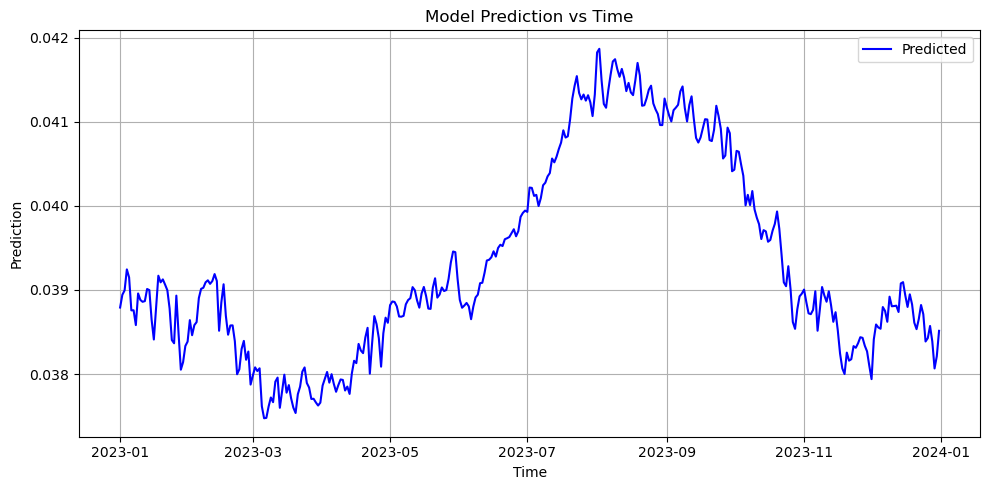

In [54]:
import matplotlib.pyplot as plt

# Assume d_23 is an xarray DataArray with a time dimension
time = d_23.time.values  # extract time values
y_pred = model1.predict(d_23.values.reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, y_pred, label="Predicted", color="blue")
plt.xlabel("Time")
plt.ylabel("Prediction")
plt.title("Model Prediction vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [52]:
d_23.values.flatten().reshape(-1, 1)

array([[0.8489863 ],
       [0.8531729 ],
       [0.85463274],
       [0.861543  ],
       [0.85891587],
       [0.8480553 ],
       [0.84808224],
       [0.84321165],
       [0.8536215 ],
       [0.85149866],
       [0.85086787],
       [0.8510996 ],
       [0.855092  ],
       [0.8547182 ],
       [0.8450265 ],
       [0.8384628 ],
       [0.848777  ],
       [0.8594628 ],
       [0.8572881 ],
       [0.858246  ],
       [0.85651755],
       [0.85468334],
       [0.84868413],
       [0.8382747 ],
       [0.83722264],
       [0.852905  ],
       [0.8402268 ],
       [0.8285256 ],
       [0.8310219 ],
       [0.8363254 ],
       [0.83777857],
       [0.8448364 ],
       [0.8398702 ],
       [0.84319574],
       [0.84418654],
       [0.8521065 ],
       [0.8551357 ],
       [0.8554971 ],
       [0.857289  ],
       [0.8579448 ],
       [0.856785  ],
       [0.8577083 ],
       [0.8599979 ],
       [0.85771877],
       [0.84134054],
       [0.8506847 ],
       [0.8566445 ],
       [0.846